In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


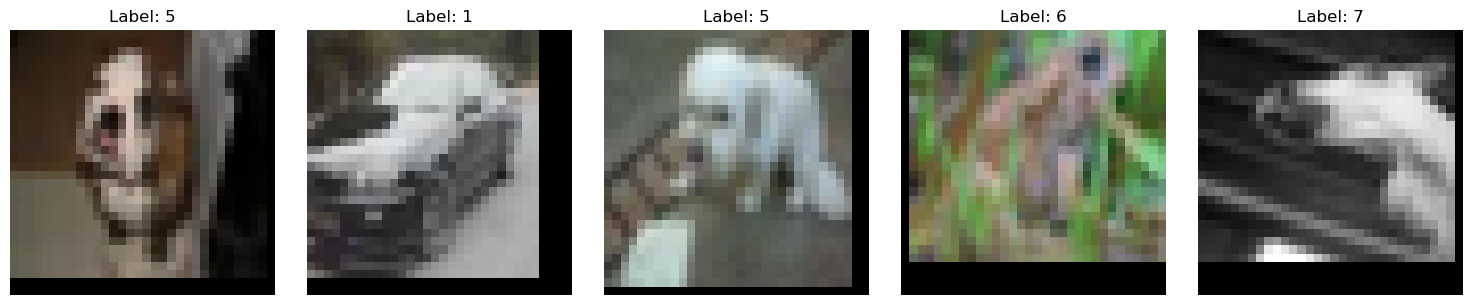

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.leaky_relu(self.bn1(self.conv1(X)), negative_slope=0.01)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.leaky_relu(Y, negative_slope=0.01)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:54<00:00,  6.43it/s]


Epoch 1 => Train Loss: 1.4475, Acc: 0.4664 | Val Loss: 1.3562, Acc: 0.5630


Epoch 2/100: 100%|██████████| 352/352 [00:51<00:00,  6.83it/s]


Epoch 2 => Train Loss: 0.9575, Acc: 0.6583 | Val Loss: 0.9763, Acc: 0.6580


Epoch 3/100: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch 3 => Train Loss: 0.7502, Acc: 0.7378 | Val Loss: 0.7113, Acc: 0.7542


Epoch 4/100: 100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Epoch 4 => Train Loss: 0.6162, Acc: 0.7850 | Val Loss: 0.6833, Acc: 0.7740


Epoch 5/100: 100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Epoch 5 => Train Loss: 0.5357, Acc: 0.8129 | Val Loss: 0.6862, Acc: 0.7840


Epoch 6/100: 100%|██████████| 352/352 [00:31<00:00, 11.11it/s]


Epoch 6 => Train Loss: 0.4744, Acc: 0.8356 | Val Loss: 0.5511, Acc: 0.8120


Epoch 7/100: 100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Epoch 7 => Train Loss: 0.4249, Acc: 0.8524 | Val Loss: 0.5459, Acc: 0.8228


Epoch 8/100: 100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Epoch 8 => Train Loss: 0.3843, Acc: 0.8673 | Val Loss: 0.4705, Acc: 0.8370


Epoch 9/100: 100%|██████████| 352/352 [00:32<00:00, 10.98it/s]


Epoch 9 => Train Loss: 0.3495, Acc: 0.8794 | Val Loss: 0.4189, Acc: 0.8652


Epoch 10/100: 100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Epoch 10 => Train Loss: 0.3229, Acc: 0.8895 | Val Loss: 0.4165, Acc: 0.8628


Epoch 11/100: 100%|██████████| 352/352 [00:33<00:00, 10.54it/s]


Epoch 11 => Train Loss: 0.2966, Acc: 0.8972 | Val Loss: 0.3881, Acc: 0.8734


Epoch 12/100: 100%|██████████| 352/352 [00:55<00:00,  6.35it/s]


Epoch 12 => Train Loss: 0.2791, Acc: 0.9032 | Val Loss: 0.4108, Acc: 0.8676


Epoch 13/100: 100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Epoch 13 => Train Loss: 0.2543, Acc: 0.9119 | Val Loss: 0.4009, Acc: 0.8766


Epoch 14/100: 100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Epoch 14 => Train Loss: 0.2350, Acc: 0.9189 | Val Loss: 0.3695, Acc: 0.8850


Epoch 15/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 15 => Train Loss: 0.2200, Acc: 0.9226 | Val Loss: 0.3334, Acc: 0.8942


Epoch 16/100: 100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Epoch 16 => Train Loss: 0.2008, Acc: 0.9295 | Val Loss: 0.3235, Acc: 0.8998


Epoch 17/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 17 => Train Loss: 0.1927, Acc: 0.9333 | Val Loss: 0.3575, Acc: 0.8870


Epoch 18/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 18 => Train Loss: 0.1770, Acc: 0.9383 | Val Loss: 0.3738, Acc: 0.8880


Epoch 19/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 19 => Train Loss: 0.1646, Acc: 0.9412 | Val Loss: 0.3473, Acc: 0.8946


Epoch 20/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 20 => Train Loss: 0.1570, Acc: 0.9444 | Val Loss: 0.3441, Acc: 0.8984


Epoch 21/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 21 => Train Loss: 0.1408, Acc: 0.9509 | Val Loss: 0.3347, Acc: 0.9020


Epoch 22/100: 100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Epoch 22 => Train Loss: 0.1348, Acc: 0.9523 | Val Loss: 0.3391, Acc: 0.8988


Epoch 23/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 23 => Train Loss: 0.1307, Acc: 0.9532 | Val Loss: 0.3714, Acc: 0.8962


Epoch 24/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 24 => Train Loss: 0.1200, Acc: 0.9569 | Val Loss: 0.3228, Acc: 0.9120


Epoch 25/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 25 => Train Loss: 0.1095, Acc: 0.9611 | Val Loss: 0.3371, Acc: 0.9072


Epoch 26/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 26 => Train Loss: 0.1101, Acc: 0.9600 | Val Loss: 0.3626, Acc: 0.9016


Epoch 27/100: 100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


Epoch 27 => Train Loss: 0.1033, Acc: 0.9640 | Val Loss: 0.3939, Acc: 0.8988


Epoch 28/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 28 => Train Loss: 0.0918, Acc: 0.9675 | Val Loss: 0.4148, Acc: 0.8968


Epoch 29/100: 100%|██████████| 352/352 [00:33<00:00, 10.56it/s]


Epoch 29 => Train Loss: 0.0926, Acc: 0.9670 | Val Loss: 0.3617, Acc: 0.9030


Epoch 30/100: 100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Epoch 30 => Train Loss: 0.0867, Acc: 0.9692 | Val Loss: 0.3538, Acc: 0.9136


Epoch 31/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 31 => Train Loss: 0.0841, Acc: 0.9702 | Val Loss: 0.3645, Acc: 0.9110


Epoch 32/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 32 => Train Loss: 0.0783, Acc: 0.9718 | Val Loss: 0.4053, Acc: 0.9018


Epoch 33/100: 100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Epoch 33 => Train Loss: 0.0817, Acc: 0.9704 | Val Loss: 0.4242, Acc: 0.9000


Epoch 34/100: 100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Epoch 34 => Train Loss: 0.0732, Acc: 0.9743 | Val Loss: 0.3499, Acc: 0.9118


Epoch 35/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 35 => Train Loss: 0.0700, Acc: 0.9744 | Val Loss: 0.4011, Acc: 0.9070


Epoch 36/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 36 => Train Loss: 0.0681, Acc: 0.9764 | Val Loss: 0.4232, Acc: 0.9018


Epoch 37/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 37 => Train Loss: 0.0596, Acc: 0.9784 | Val Loss: 0.3870, Acc: 0.9114


Epoch 38/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 38 => Train Loss: 0.0629, Acc: 0.9783 | Val Loss: 0.3649, Acc: 0.9142


Epoch 39/100: 100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Epoch 39 => Train Loss: 0.0633, Acc: 0.9782 | Val Loss: 0.3799, Acc: 0.9102


Epoch 40/100: 100%|██████████| 352/352 [00:29<00:00, 11.85it/s]


Epoch 40 => Train Loss: 0.0596, Acc: 0.9796 | Val Loss: 0.3900, Acc: 0.9080


Epoch 41/100: 100%|██████████| 352/352 [00:29<00:00, 11.91it/s]


Epoch 41 => Train Loss: 0.0550, Acc: 0.9808 | Val Loss: 0.4056, Acc: 0.9080


Epoch 42/100: 100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Epoch 42 => Train Loss: 0.0585, Acc: 0.9800 | Val Loss: 0.3920, Acc: 0.9094


Epoch 43/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 43 => Train Loss: 0.0554, Acc: 0.9807 | Val Loss: 0.3602, Acc: 0.9140


Epoch 44/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 44 => Train Loss: 0.0495, Acc: 0.9829 | Val Loss: 0.4032, Acc: 0.9166


Epoch 45/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 45 => Train Loss: 0.0483, Acc: 0.9832 | Val Loss: 0.4037, Acc: 0.9084


Epoch 46/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 46 => Train Loss: 0.0530, Acc: 0.9812 | Val Loss: 0.3798, Acc: 0.9168


Epoch 47/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 47 => Train Loss: 0.0477, Acc: 0.9835 | Val Loss: 0.4120, Acc: 0.9178


Epoch 48/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 48 => Train Loss: 0.0452, Acc: 0.9841 | Val Loss: 0.4061, Acc: 0.9134


Epoch 49/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 49 => Train Loss: 0.0422, Acc: 0.9853 | Val Loss: 0.4136, Acc: 0.9142


Epoch 50/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 50 => Train Loss: 0.0446, Acc: 0.9846 | Val Loss: 0.4007, Acc: 0.9162


Epoch 51/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 51 => Train Loss: 0.0480, Acc: 0.9835 | Val Loss: 0.3778, Acc: 0.9204


Epoch 52/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 52 => Train Loss: 0.0414, Acc: 0.9852 | Val Loss: 0.3729, Acc: 0.9200


Epoch 53/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 53 => Train Loss: 0.0401, Acc: 0.9861 | Val Loss: 0.4462, Acc: 0.9110


Epoch 54/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 54 => Train Loss: 0.0453, Acc: 0.9837 | Val Loss: 0.3910, Acc: 0.9156


Epoch 55/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 55 => Train Loss: 0.0345, Acc: 0.9877 | Val Loss: 0.4041, Acc: 0.9222


Epoch 56/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 56 => Train Loss: 0.0378, Acc: 0.9872 | Val Loss: 0.4237, Acc: 0.9152


Epoch 57/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 57 => Train Loss: 0.0438, Acc: 0.9845 | Val Loss: 0.4130, Acc: 0.9158


Epoch 58/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 58 => Train Loss: 0.0378, Acc: 0.9871 | Val Loss: 0.4081, Acc: 0.9190


Epoch 59/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 59 => Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.4165, Acc: 0.9186


Epoch 60/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 60 => Train Loss: 0.0394, Acc: 0.9857 | Val Loss: 0.4535, Acc: 0.9184


Epoch 61/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 61 => Train Loss: 0.0374, Acc: 0.9872 | Val Loss: 0.4165, Acc: 0.9172


Epoch 62/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 62 => Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.4689, Acc: 0.9146


Epoch 63/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 63 => Train Loss: 0.0354, Acc: 0.9878 | Val Loss: 0.4381, Acc: 0.9162


Epoch 64/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 64 => Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.4404, Acc: 0.9172


Epoch 65/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 65 => Train Loss: 0.0347, Acc: 0.9881 | Val Loss: 0.4177, Acc: 0.9226


Epoch 66/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 66 => Train Loss: 0.0326, Acc: 0.9887 | Val Loss: 0.4114, Acc: 0.9146


Epoch 67/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 67 => Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.4588, Acc: 0.9160


Epoch 68/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 68 => Train Loss: 0.0316, Acc: 0.9891 | Val Loss: 0.4568, Acc: 0.9140


Epoch 69/100: 100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Epoch 69 => Train Loss: 0.0338, Acc: 0.9880 | Val Loss: 0.4299, Acc: 0.9166


Epoch 70/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 70 => Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.4481, Acc: 0.9164


Epoch 71/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 71 => Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.4791, Acc: 0.9098


Epoch 72/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 72 => Train Loss: 0.0289, Acc: 0.9897 | Val Loss: 0.4439, Acc: 0.9184


Epoch 73/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 73 => Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.4185, Acc: 0.9192


Epoch 74/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 74 => Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.4162, Acc: 0.9234


Epoch 75/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 75 => Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.4418, Acc: 0.9208


Epoch 76/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 76 => Train Loss: 0.0333, Acc: 0.9882 | Val Loss: 0.4037, Acc: 0.9248


Epoch 77/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 77 => Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.3972, Acc: 0.9242


Epoch 78/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 78 => Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.4112, Acc: 0.9202


Epoch 79/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 79 => Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.4351, Acc: 0.9188


Epoch 80/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 80 => Train Loss: 0.0248, Acc: 0.9914 | Val Loss: 0.4559, Acc: 0.9160


Epoch 81/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 81 => Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.4232, Acc: 0.9172


Epoch 82/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 82 => Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 0.4162, Acc: 0.9214


Epoch 83/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 83 => Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.4411, Acc: 0.9190


Epoch 84/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 84 => Train Loss: 0.0252, Acc: 0.9912 | Val Loss: 0.4215, Acc: 0.9206


Epoch 85/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 85 => Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.4288, Acc: 0.9188


Epoch 86/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 86 => Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.4316, Acc: 0.9146


Epoch 87/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 87 => Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.4883, Acc: 0.9144


Epoch 88/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 88 => Train Loss: 0.0258, Acc: 0.9908 | Val Loss: 0.4685, Acc: 0.9144


Epoch 89/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 89 => Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.4476, Acc: 0.9216


Epoch 90/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 90 => Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.4684, Acc: 0.9206


Epoch 91/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 91 => Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.4291, Acc: 0.9176


Epoch 92/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 92 => Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.4565, Acc: 0.9214


Epoch 93/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 93 => Train Loss: 0.0229, Acc: 0.9918 | Val Loss: 0.4236, Acc: 0.9238


Epoch 94/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 94 => Train Loss: 0.0198, Acc: 0.9930 | Val Loss: 0.4656, Acc: 0.9190


Epoch 95/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 95 => Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.4508, Acc: 0.9196


Epoch 96/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 96 => Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.4763, Acc: 0.9196


Epoch 97/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 97 => Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.4737, Acc: 0.9174


Epoch 98/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 98 => Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.4369, Acc: 0.9170


Epoch 99/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 99 => Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.4625, Acc: 0.9218


Epoch 100/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 100 => Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.4822, Acc: 0.9172


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adam_leakyrelu.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

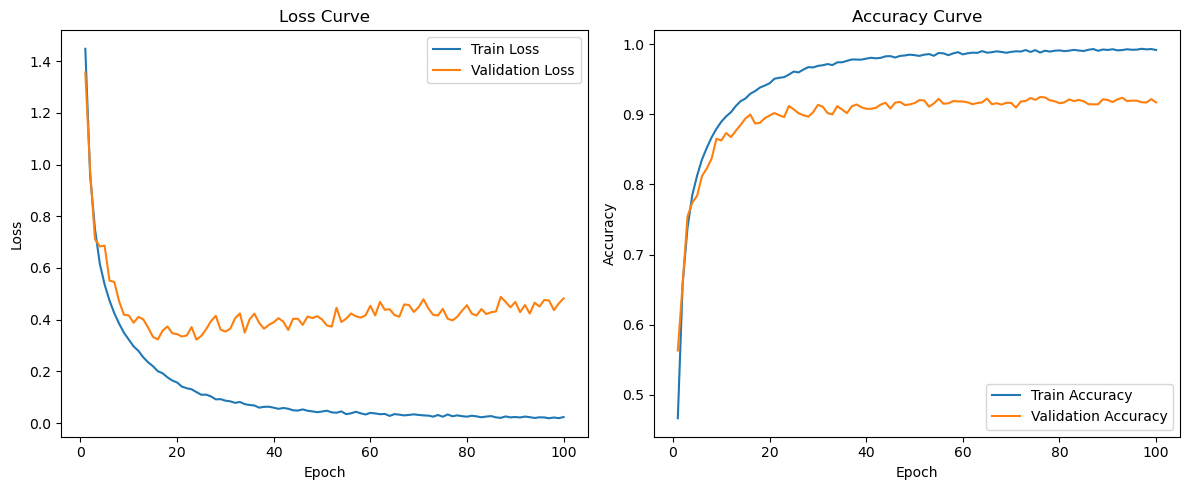

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [16]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.01%


In [17]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.37%
